# <center>Projeto - Aprendizado de Máquina</center>
## <center>Ramon Gonçalves Gonze</center>

# <center>--- Crimes em Chicago ---</center>
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import geopy.distance
import datetime
import seaborn as sns
import keras
from matplotlib import rcParams
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense 
from sklearn import tree

# Modelos 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
import sklearn as sk
from IPython.display import Image

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

sns.set()
%matplotlib inline

np.random.seed(42)

Using TensorFlow backend.


In [2]:
def plot_dist(data_,label,title,threshold=None):
    data = data_.copy()
    data[label].unique()
    df = data[[label,'ID']]
    df = df.groupby([label]).count()
    if(threshold):
        df = df[df["ID"]>threshold]
    
    df = df.sort_values('ID')
    plt.figure(figsize=(8,8))
    plt.barh(df.index,df["ID"])
    plt.title(title, fontsize=15)
    plt.rc('xtick',labelsize=10)
    plt.show()
    
def plot_binary(yes,no,label):
    objects = ('Sim', 'Não')
    y_pos = np.arange(len(objects))
    size = [ff,tt]
    
    plt.figure(figsize=(5,5))
    plt.bar(y_pos, size, align='center')
    plt.xticks(y_pos, objects)
    plt.title(label)

---
# <center>--- Base de dados ---</center>
---

A base de dados é composta por crimes que ocorreram na cidade de Chicago entre os anos de 2001 e 2019, inclusive. Cada registro da base de dados é um crime, e há as seguintes informações sobre cada crime:
- Número do caso (ID interno do Departamento de Polícia de Chicago)
- Data
- Região (a cidade é dividida em 77 regiões)
- Local (rua, apartamento, loja comercial, ...)
- Tipo de crime (assalto, roubo, sequestro, ...)
- Resultou em prisão
- ...

O objetivo deste trabalho é construir um modelo que utilizará dados do passado para ser treinado, porém, ele deve possuir utilidade para novos registros (novos crimes). Por este motivo foram selecionadas features que são informações óbvias que possuímos sobre novos crimes. As features selecionadas foram:
- Região
- Local
- Resultou em prisão

O dataset possui dados sobre crimes ocorridos desde 2001 até 2019. O dataset completo possui cerca de 6,8 milhões de regitros, e por este motivo, optamos por analisar somente os dados dos anos de 2015 até 2018 (aproximadamente 1 milhão de registros).

O conjunto de teste é composto pelos registro dos anos de 2015~2017, e o conjunto de teste são os registros do anos de 2018. Neste trabalho propomos utilizar 4 modelos para realizar as predições:
- Naive Bayes
- Decision Tree
- Random Forest
- AdaBoost

A base de dados completa é pública e está disponível no seguinte link: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2.

A base de dados utilizada neste arquivo (um recorte dos anos de 2015 até 2018) está disponível em um repositório no GitHub: https://github.com/ramongonze/ml-project

In [31]:
data = pd.read_csv('Crimes_2015_to_2018.csv')
data.dropna(inplace=True) # Remove examples with 'NaN' values in any column
data.reset_index(drop=True, inplace=True)

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Replace string values by integers.
Creates a feature map, from string labels to integer labels
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
selected_features = ['Community Area', 'Location Description']
features_to_integer = ['Community Area', 'Location Description', 'Arrest']
featureMap = {}
data_int = data.copy()
for f in features_to_integer:
    featureMap[f], index = {}, 0

    for value in list(data_int[f].unique()):
        featureMap[f][value] = index
        index += 1

    data_int[f] = data_int[f].apply(lambda x : featureMap[f][x])
   
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Split the main dataset into X and Y and in train and test.
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
train = data_int[data_int['Year'] < 2018].copy() # Crimes in 2015-2017
test = data_int[data_int['Year'] == 2018].copy() # Crimes in 2018

# Spliting in X and Y
xTrain = train[selected_features].copy()
yTrain = train['Arrest'].copy()
xTest = test[selected_features].copy()
yTest = test['Arrest'].copy()

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Creates another dataset tranforming the features using
one hot enconding.
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
data_OH = data_int.copy()

# Spliting training and testing sets
train_OH = data_int[data_int['Year'] < 2018].copy() # Crimes in 2015-2017
test_OH = data_int[data_int['Year'] == 2018].copy() # Crimes in 2018

# Spliting in X and Y
xTrain_OH = train[selected_features].copy().reset_index(drop=True)
yTrain_OH = train['Arrest'].copy().reset_index(drop=True)
xTest_OH = test[selected_features].copy().reset_index(drop=True)
yTest_OH = test['Arrest'].copy().reset_index(drop=True)

oh = to_categorical(xTrain_OH['Location Description'].values, dtype='int', num_classes=155)
del(xTrain_OH['Location Description'])
xTrain_OH = pd.concat([xTrain_OH, pd.DataFrame(oh.copy())], axis=1)
oh = to_categorical(xTest_OH['Location Description'].values, dtype='int', num_classes=155)
del(xTest_OH['Location Description'])
xTest_OH = pd.concat([xTest_OH, pd.DataFrame(oh.copy())], axis=1)

oh = to_categorical(xTrain_OH['Community Area'].values, dtype='int', num_classes=77)
del(xTrain_OH['Community Area'])
xTrain_OH = pd.concat([pd.DataFrame(oh.copy()), xTrain_OH], axis=1)
oh = to_categorical(xTest_OH['Community Area'].values, dtype='int', num_classes=77)
del(xTest_OH['Community Area'])
xTest_OH = pd.concat([pd.DataFrame(oh.copy()), xTest_OH], axis=1)

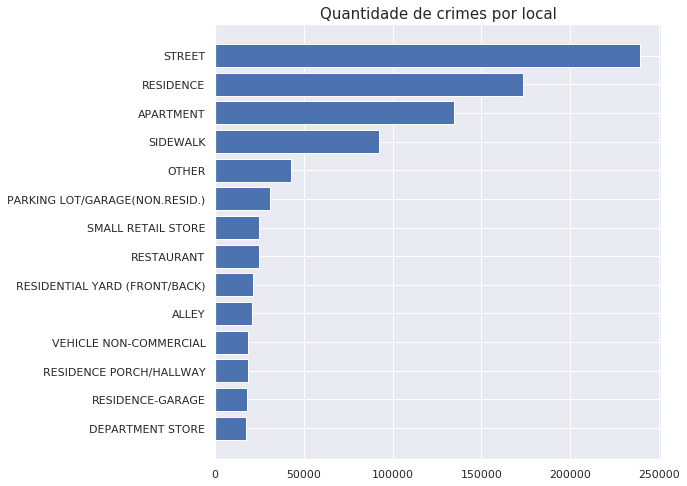

In [4]:
plot_dist(data,'Location Description','Quantidade de crimes por local', threshold=15000)

O gráfico de barras acima nos mostra o desbalanceamento em relação à quantidade de crimes que ocorrem em diferentes locais. Há uma distribuição *de cauda* entre os locais onde ocorreram os crimes.

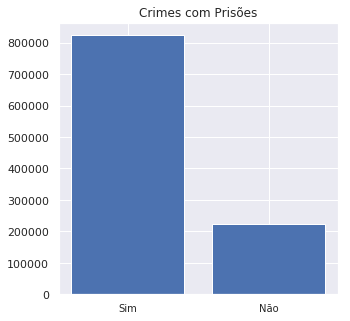

In [5]:
ff = len(data[data['Arrest']==False])
tt = len(data[data['Arrest']==True])
sz = ff+tt

plot_binary(tt,ff,'Crimes com Prisões')

O gráfico acima nos mostra um desbalanceamento entre o número de crimes que resultam em prisão ou não. Cerca de 80% dos crimes resultaram em prisão, enquanto que 20% não. 

Por este motivo, alguns critérios não podem ser utilizados para comprar os modelos. Um destes critérios é a acurácia: Se o modelo optar por responder 'Sim' para todas as entradas, ele obterá em média 80% de acurácia. De fato, foram realizadas comparações nas acurácias, e os 4 modelos obtiveram acurácias próximas de 80%. 

A métrica utilizada para comparar os modelos foi a *AUC* (Area under the curve). Ao contrário da acurácia, a AUC nos permite comparar os modelos mesmo em datasets que possuem classes desproporcionais.

---
# <center>--- Modelos ---</center>
---

## Naive Bayes

In [6]:
nb = GaussianNB()
nb.fit(xTrain, yTrain)
nb_yPred = nb.predict_proba(xTest)[:, 1]
nb_fpr, nb_tpr, thresholds_nb = roc_curve(yTest, nb_yPred)
nb_auc = auc(nb_fpr, nb_tpr)
print('Naive Bayes AUC: %.2f%%'%(nb_auc*100))

Naive Bayes AUC: 55.35%


---
## Decision Tree

In [7]:
depths = [None] + list(np.arange(1,20))
dtree_aucs = np.array([])
for d in depths:
    dtree = DecisionTreeClassifier(max_depth=d, criterion='entropy')
    dtree.fit(xTrain_OH, yTrain_OH)
    
    dtree_yPred = dtree.predict_proba(xTest_OH)[:, 1]
    dtree_fpr, dtree_tpr, thresholds_dtree = roc_curve(yTest_OH, dtree_yPred)
    dtree_auc = auc(dtree_fpr, dtree_tpr)
    
    dtree_aucs = np.append(dtree_aucs, dtree_auc)

print('Decision Tree AUC: %.2f%% -- Max depth: %d'%(max(dtree_aucs)*100, dtree_aucs.argmax()+1))

Decision Tree AUC: 71.31% -- Max depth: 1


---
## Random Forest

In [8]:
rf_aucs = np.array([])
for n_trees in np.arange(70,100):
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth=15, n_jobs=12)
    rf.fit(xTrain_OH, yTrain_OH)
    
    rf_yPred = rf.predict_proba(xTest_OH)[:, 1]
    rf_fpr, rf_tpr, thresholds_rf = roc_curve(yTest_OH, rf_yPred)
    rf_auc = auc(rf_fpr, rf_tpr)
    
    rf_aucs = np.append(rf_aucs, rf_auc)

print('Random Forest AUC: %.2f%% -- # trees: %d'%(max(rf_aucs)*100, rf_aucs.argmax()+71))

Random Forest AUC: 69.10% -- # trees: 84


---
## AdaBoost

In [9]:
ada_aucs = np.array([])
for n_stumps in np.arange(1,30):
    ada = AdaBoostClassifier(n_estimators=n_stumps)
    ada.fit(xTrain_OH, yTrain_OH)
    
    ada_yPred = ada.predict_proba(xTest_OH)[:, 1]
    ada_fpr, ada_tpr, thresholds_ada = roc_curve(yTest_OH, ada_yPred)
    ada_auc = auc(ada_fpr, ada_tpr)

    ada_aucs = np.append(ada_aucs, ada_auc)
    
print('AdaBoost AUC: %.2f%% -- # stumps: %d'%(max(ada_aucs)*100, ada_aucs.argmax()+1))

AdaBoost AUC: 67.67% -- # stumps: 29


----
# <center>--- Comparação dos modelos ---</center>
---

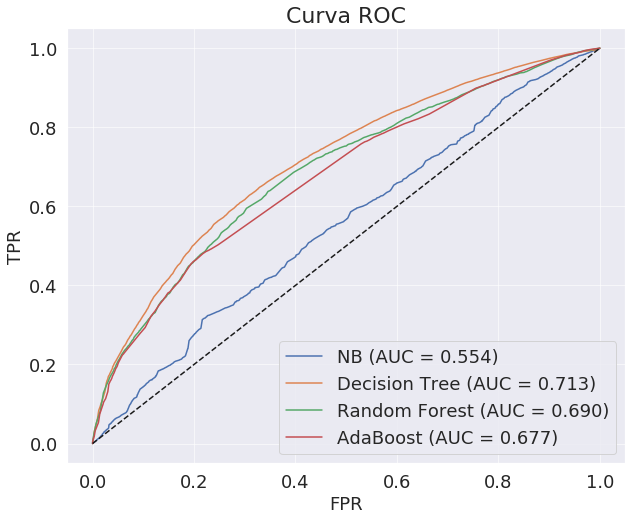

In [35]:
# Decision Tree
dtree = DecisionTreeClassifier(max_depth=None, criterion='entropy')
dtree.fit(xTrain_OH, yTrain_OH)
dtree_yPred = dtree.predict_proba(xTest_OH)[:, 1]
dtree_fpr, dtree_tpr, thresholds_nb = roc_curve(yTest_OH, dtree_yPred)
dtree_auc = auc(dtree_fpr, dtree_tpr)

# Random Forest
rf = RandomForestClassifier(n_estimators=rf_aucs.argmax()+71, max_depth=15, n_jobs=12)
rf.fit(xTrain_OH, yTrain_OH)
rf_yPred = rf.predict_proba(xTest_OH)[:, 1]
rf_fpr, rf_tpr, thresholds_ada = roc_curve(yTest_OH, rf_yPred)
rf_auc = auc(rf_fpr, rf_tpr)

X1, Y1, AUC1 = rf_fpr.copy(), rf_tpr.copy(), rf_auc.copy()

# AdaBoost
ada = AdaBoostClassifier(n_estimators=ada_aucs.argmax()+1)
ada.fit(xTrain_OH, yTrain_OH)
ada_yPred = ada.predict_proba(xTest_OH)[:, 1]
ada_fpr, ada_tpr, thresholds_ada = roc_curve(yTest_OH, ada_yPred)
ada_auc = auc(ada_fpr, ada_tpr)

plt.figure(figsize=(10,8))
plt.plot(nb_fpr, nb_tpr, label='NB (AUC = {:.3f})'.format(nb_auc))
plt.plot(dtree_fpr, dtree_tpr, label='Decision Tree (AUC = {:.3f})'.format(dtree_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.3f})'.format(rf_auc))
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (AUC = {:.3f})'.format(ada_auc))
plt.plot([0,1], [0, 1], 'k--')
plt.title('Curva ROC', fontsize=22)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.legend(fontsize=18, loc='lower right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(alpha=0.6)
plt.show()

A curva ROC acima permite compararmos o desempenho dos 4 modelos. Em todos, a AUC foi inferior a 72%, e este *pode* ser um indício de que talvez a correlação entre *Local*, *Região* e *Resulta em prisão* não seja tão alta. 

A AUC máxima foi alcançada pela Decision Tree, com o valor de 71,31%.

## Precision, Recall e F1 - Random Forest

In [13]:
rfbin_yPred = rf.predict(xTest_OH)
metrics = pd.DataFrame(np.transpose(precision_recall_fscore_support(yTest_OH, rfbin_yPred)), \
                       columns=['Precision', 'Recall', 'F1', 'Support'],\
                       index=['Not Arrest', 'Arrest'])

metrics

,Precision,Recall,F1,Support
Not Arrest,0.802771,0.998228,0.889894,209399.0
Arrest,0.717010,0.017975,0.035071,52295.0


Apesar da AUC alcançada pelo Random Forest ser apenas 69%, o precision foi cerca de 80,27% para a classe "Não resulta em prisão", e um recall de 99,22%. Em um cenário onde o modelo pode ser utilizado para formular estratégias para prender o criminoso, valores altos de precision e recall para a classe "Não resulta em prisão" são bons índices de confiabilidade do modelo.

---
# <center>*Feature Viatura*</center>
---

Uma outra análisa realizada neste trabalho é em relação à feature *Viatura*. O dataset informa o número da viatura policial que atendeu o crime.

A princípio, espera-se que as equipes policiais tenham um desempenho semelhante em campo, tenham uma qualidade similiar. As equipes policiais possuírem uma divergência de qualidade muito alta, é um mal sinal.

Como utilizar os modelos acima para verificar uma possível divergência de qualidade nas equipes?

A ideia principal é executar dois modelos, um que possui a feature *Viatura* nos conjuntos de treino e teste (juntamente com *Local* e *Região*, e o outro não utilizar a feature (os modelos apresentados até o momento).
A partir de dois comportamentos possíveis, foram pensadas duas conclusões:

- Se o modelo *que __utiliza__ a feature Viatura* possuir uma diferença de desempenho **significativa** em comparação ao modelo *sem a feature*, é um sinal de que o modelo está usando a feature como decisão, isto é, é possível que as equipes policiais possuam uma divergência **significativa** de qualidade.
- Se o modelo *que __não utiliza__ a feature Viatura* não divergir significativamente no desempenho em comparação ao outro modelo, é possível que as equipes policiais possuam um nível considerável de equilíbrio na qualidade.

Para realizar esta comparação, executamos o Random Forest para as duas configurações.

In [14]:
DATA = data.copy()

selected_features = ['Community Area', 'Location Description', 'Beat']
features_to_integer = ['Community Area', 'Location Description', 'Arrest']
featureMap = {}
DATA_int = DATA.copy()
for f in features_to_integer:
    featureMap[f], index = {}, 0

    for value in list(data_int[f].unique()):
        featureMap[f][value] = index
        index += 1

    DATA_int[f] = data_int[f].apply(lambda x : featureMap[f][x])
    
# Spliting training and testing sets
train = DATA_int[data_int['Year'] < 2018].copy() # Crimes in 2015-2017
test = DATA_int[data_int['Year'] == 2018].copy() # Crimes in 2018

# Spliting in X and Y
xTrain = train[selected_features].copy()
yTrain = train['Arrest'].copy()
xTest = test[selected_features].copy()
yTest = test['Arrest'].copy()

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Creates another dataset tranforming the features using
one hot enconding.
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
data_OH = data_int.copy()

# Spliting training and testing sets
train_OH = DATA_int[data_int['Year'] < 2018].copy() # Crimes in 2015-2017
test_OH = DATA_int[data_int['Year'] == 2018].copy() # Crimes in 2018

# Spliting in X and Y
xTrain_OH = train[selected_features].copy().reset_index(drop=True)
yTrain_OH = train['Arrest'].copy().reset_index(drop=True)
xTest_OH = test[selected_features].copy().reset_index(drop=True)
yTest_OH = test['Arrest'].copy().reset_index(drop=True)

oh = to_categorical(xTrain_OH['Location Description'].values, dtype='int', num_classes=155)
del(xTrain_OH['Location Description'])
xTrain_OH = pd.concat([xTrain_OH, pd.DataFrame(oh.copy())], axis=1)
oh = to_categorical(xTest_OH['Location Description'].values, dtype='int', num_classes=155)
del(xTest_OH['Location Description'])
xTest_OH = pd.concat([xTest_OH, pd.DataFrame(oh.copy())], axis=1)

oh = to_categorical(xTrain_OH['Community Area'].values, dtype='int', num_classes=77)
del(xTrain_OH['Community Area'])
xTrain_OH = pd.concat([pd.DataFrame(oh.copy()), xTrain_OH], axis=1)
oh = to_categorical(xTest_OH['Community Area'].values, dtype='int', num_classes=77)
del(xTest_OH['Community Area'])
xTest_OH = pd.concat([pd.DataFrame(oh.copy()), xTest_OH], axis=1)

In [15]:
# Random Forest
rf = RandomForestClassifier(n_estimators=rf_aucs.argmax()+71, max_depth=15, n_jobs=12)
rf.fit(xTrain_OH, yTrain_OH)
rf_yPred = rf.predict_proba(xTest_OH)[:, 1]
rf_fpr, rf_tpr, thresholds_ada = roc_curve(yTest_OH, rf_yPred)
rf_auc = auc(rf_fpr, rf_tpr)

X2, Y2, AUC2 = rf_fpr.copy(), rf_tpr.copy(), rf_auc.copy()

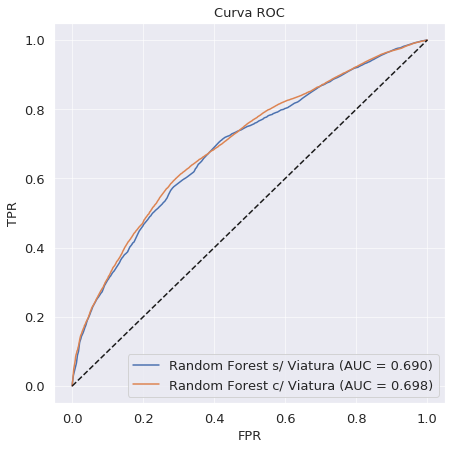

In [21]:
plt.figure(figsize=(7,7))
plt.plot(X1, Y1, label='Random Forest s/ Viatura (AUC = {:.3f})'.format(AUC1))
plt.plot(X2, Y2, label='Random Forest c/ Viatura (AUC = {:.3f})'.format(AUC2))
plt.plot([0,1], [0, 1], 'k--')
plt.title('Curva ROC', fontsize=13)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.legend(fontsize=13, loc='lower right')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(alpha=0.6)
plt.show()

Como podemos observar no gráfico acima, o comportamento da curva ROC de ambos os modelos são semelhantes, e não possuem uma divergência significativa. Por esse motivo podemos concluir que *é possível* que as equipes policiais da cidade de Chicago possuem uma qualidade semelhante entre si.